# Introduction
Before starting this tutorial, you'll need to have at least one sequence from the Boreas dataset downloaded.
If you're working on a local machine, follow these steps to download a sequence:
1. [Create an AWS account](https://aws.amazon.com/premiumsupport/knowledge-center/create-and-activate-aws-account/)
2. [Install the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2.html)
3. Create a `root` folder to store the dataset, example: `/path/to/data/boreas/` Each sequence will then be a folder under `root`.
4. Use the AWS CLI to download a sequence:
```
root = '/home/tim-external/dataFolder/radar_boreas/'
sequence=boreas-2021-09-02-11-42
aws s3 sync s3://boreas/$sequence $root$sequence
```

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pyboreas import BoreasDataset
from pyboreas.utils.utils import get_inverse_tf

root = '/home/tim-external/dataFolder/radar_boreas/'
split = None
# AWS: Note: Free Tier SageMaker instances don't have enough storage (25 GB) for 1 sequence (100 GB)
# root = '/home/ec2-user/SageMaker/boreas/'
# split = [['boreas-2021-09-02-11-42', 163059759e6, 163059760e6-1]]

# With verbose=True, the following will print information about each sequence
bd = BoreasDataset(root, split=split, verbose=True)
# Grab the first sequence
seq = bd.sequences[1]

SEQ: boreas-2020-11-26-13-58
camera frames: 20624
lidar frames: 9984
radar frames: 4142
-------------------------------
SEQ: boreas-2021-09-02-11-42
camera frames: 10293
lidar frames: 9967
radar frames: 4134
-------------------------------
total camera frames: 30917
total lidar frames: 19951
total radar frames: 8276


In [10]:
# Each sequence has it's own calibration:
seq.calib.print_calibration()

P0:
[[1.44015857e+03 0.00000000e+00 1.21822773e+03 0.00000000e+00]
 [0.00000000e+00 1.44692151e+03 1.04527215e+03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
T_applanix_aeva:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
T_applanix_lidar:
[[ 0.73605557 -0.67692112  0.          0.        ]
 [ 0.67692112  0.73605557  0.          0.        ]
 [ 0.          0.          1.          0.13      ]
 [ 0.          0.          0.          1.        ]]
T_camera_lidar:
[[ 7.29304195e-01 -6.84189392e-01 -5.16788457e-04 -2.31487194e-02]
 [-1.28793478e-02 -1.29733965e-02 -9.99832893e-01 -2.29363449e-01]
 [ 6.84068355e-01  7.29188978e-01 -1.82734656e-02 -6.35346228e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
T_radar_lidar:
[[ 0.68233939  0.73103554  0.          0.        ]
 [ 0.73103554 -0.68233939  0.          0.        ]
 [ 0.          0.         -1.          0

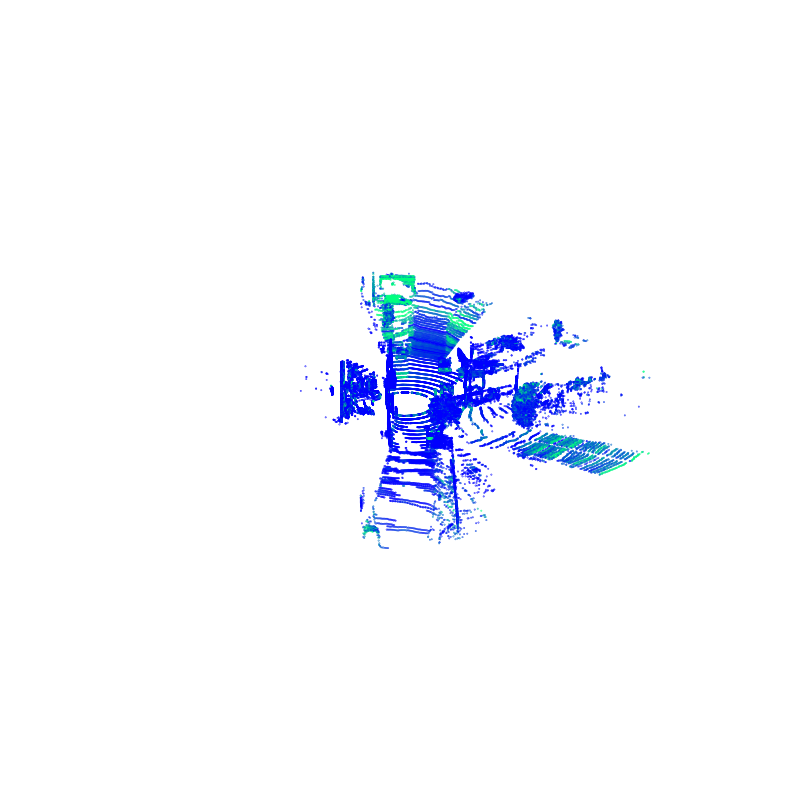

<Axes3D: >

In [11]:
# matplotlib inline
# Let's visualize a lidar frame:
lid = seq.get_lidar(0)
lid.passthrough([-40, 40, -40, 40, -10, 30])
lid.visualize(figsize=(10, 10), color='intensity', vmin=5, vmax=40)

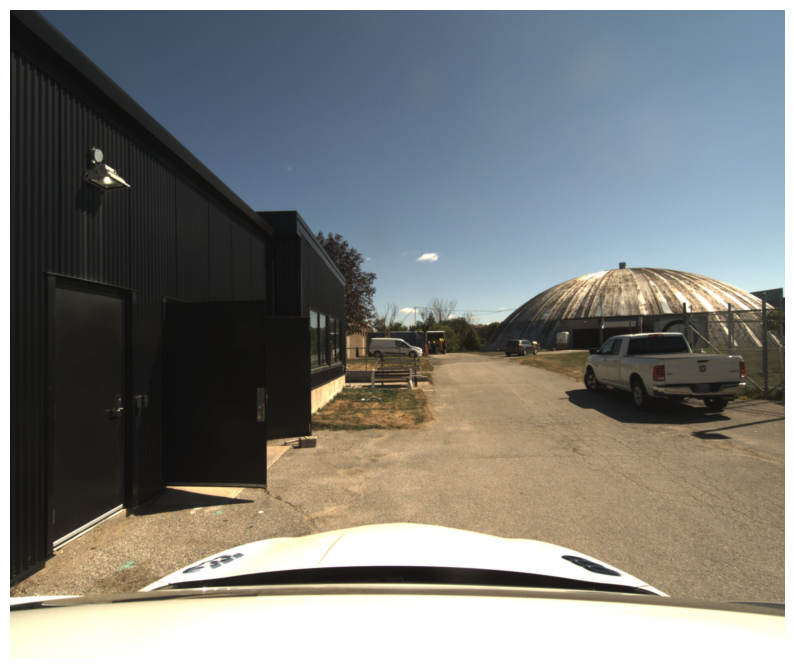

<Axes: >

In [12]:
# Now let's visualize the first camera frame:
cam = seq.get_camera(0)
cam.visualize(figsize=(10, 10))

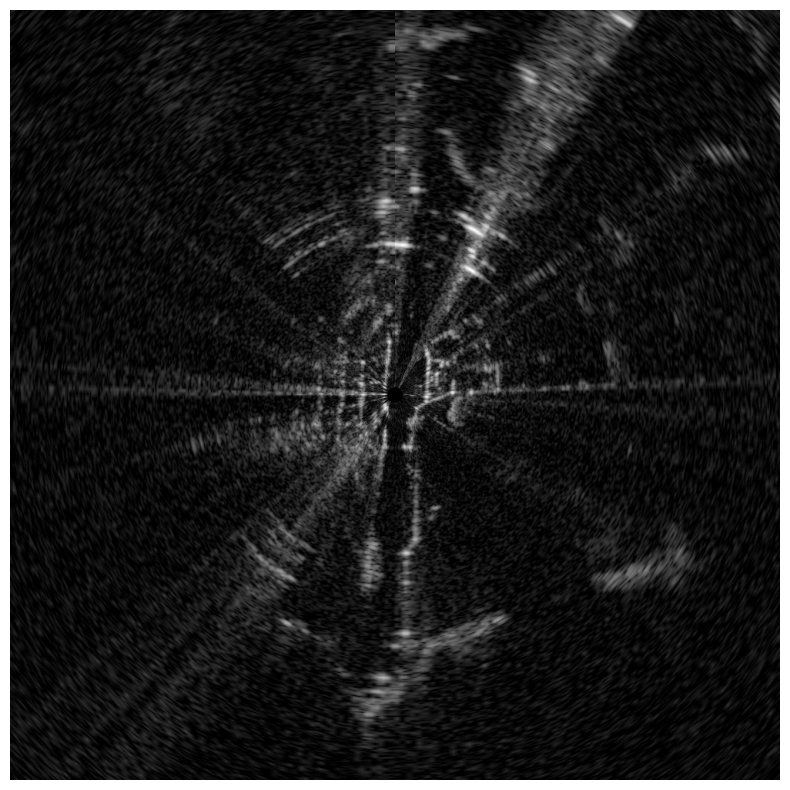

<Axes: >

In [13]:
# Now let's visualize the first radar frame:
rad = seq.get_radar(0)
rad.visualize(cart_resolution=0.25, cart_pixel_width=1000)

In [14]:
# Note that each sensor frame has a timestamp, pose (4x4 homogeneous transform), and velocity information.
lid = seq.get_lidar(0)
print('Lidar:')
print('timestamp: {}'.format(lid.timestamp))
print('pose (T_enu_lidar):')
print(lid.pose)
print('velocity (wrt ENU):')
print(lid.velocity)
print('body rate (wrt sensor):')
print(lid.body_rate)

# Note that lidar and camera frames are collected at 10Hz, but radar frames collected at 4 Hz.

Lidar:
timestamp: 1630597330.954834
pose (T_enu_lidar):
[[ 0.84784756  0.52962159 -0.02560238 -5.03440968]
 [-0.53015757  0.84757856 -0.02331397  0.35995779]
 [ 0.00935245  0.03333999  0.99940031  0.01904589]
 [ 0.          0.          0.          1.        ]]
velocity (wrt ENU):
[[ 0.00104909]
 [-0.00029213]
 [ 0.00046324]
 [ 0.00227622]
 [ 0.00720723]
 [-0.00042424]]
body rate (wrt sensor):
[[ 0.00104868]
 [ 0.00032346]
 [ 0.00044292]
 [-0.00189504]
 [ 0.00730008]
 [-0.00065029]]


In [15]:
# To transform data from one frame to another, use the poses
index = 0
lid = seq.get_lidar(index)
p_lid = np.array([1, 0, 0, 1]).reshape(4, 1)
print('point in lidar frame')
print(p_lid)
print('lidar pose (T_enu_lidar) at time: {}'.format(lid.timestamp))
T_enu_lidar = lid.pose
print(T_enu_lidar)

# **Important: camera, lidar, radar measurements are NOT synchronous
# camera frame X does not necessarily correspond to lidar frame X
# They may be close, but will have been collected at different times, see below:
cam = seq.get_camera(index)
print('camera pose (T_enu_camera) at time: {}'.format(cam.timestamp))
T_enu_camera = cam.pose
print(T_enu_camera)

T_camera_lidar = np.matmul(get_inverse_tf(T_enu_camera), T_enu_lidar)
print('T_camera_lidar:')
print(T_camera_lidar)
print('distance: {}'.format(np.linalg.norm(T_camera_lidar[:3, 3])))

print('point in camera frame:')
p_cam = np.matmul(T_camera_lidar, p_lid)
print(p_cam)

point in lidar frame
[[1]
 [0]
 [0]
 [1]]
lidar pose (T_enu_lidar) at time: 1630597330.954834
[[ 0.84784756  0.52962159 -0.02560238 -5.03440968]
 [-0.53015757  0.84757856 -0.02331397  0.35995779]
 [ 0.00935245  0.03333999  0.99940031  0.01904589]
 [ 0.          0.          0.          1.        ]]
camera pose (T_enu_camera) at time: 1630597331.0276809
[[ 0.25599633  0.00784527  0.96664592 -4.41253539]
 [-0.96653706  0.0191373   0.25581218  0.5045024 ]
 [-0.01649208 -0.99978608  0.01248183 -0.20272349]
 [ 0.          0.          0.          1.        ]]
T_camera_lidar:
[[ 7.29308558e-01 -6.84184752e-01 -5.02488766e-04 -2.31472453e-02]
 [-1.28446376e-02 -1.29574635e-02 -9.99833546e-01 -2.29366909e-01]
 [ 6.84064356e-01  7.29193616e-01 -1.82380942e-02 -6.35340425e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
distance: 0.6758716076256036
point in camera frame:
[[ 0.70616131]
 [-0.24221155]
 [ 0.04872393]
 [ 1.        ]]


In [17]:
# Example: using an iterator
cam_iter = bd.sequences[1].get_camera_iter()
cam0 = next(cam_iter)  # First camera frame
cam1 = next(cam_iter)  # Second camera frame
print(cam0.timestamp)
print(cam1.timestamp)

1630597331.0276809
1630597331.127683
